In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import os
import kaggle_evaluation.default_inference_server

In [2]:
# Load data
train = pd.read_csv("/kaggle/input/hull-tactical-market-prediction/train.csv")
test = pd.read_csv("/kaggle/input/hull-tactical-market-prediction/test.csv")

# Columns to keep
test_cols = ["M1", "E1", "I1", "P1", "V1", "S1", "D1"]
train_cols = ["forward_returns", "risk_free_rate", "market_forward_excess_returns"]
base_col = ["date_id"]

# Apply filtering
train_filtered = train[base_col + test_cols + train_cols]
test_filtered = test[base_col + test_cols]

window = 50 # number of days in each normalization window

rolling_min = train_filtered["market_forward_excess_returns"].rolling(window).min()
rolling_max = train_filtered["market_forward_excess_returns"].rolling(window).max()

train_filtered["target_market_norm"] = (
    (train_filtered["forward_returns"] - rolling_min) / (rolling_max - rolling_min)
)
train_filtered["target_market_norm"].bfill(inplace=True)

# remove duplicate colums
train_filtered = train_filtered.loc[:, ~train_filtered.columns.duplicated()]
test_filtered = test_filtered.loc[:, ~test_filtered.columns.duplicated()]

print(f"Number of rows in train: {len(train_filtered)}")
print(f"Number of rows in test: {len(test_filtered)}")

Number of rows in train: 8990
Number of rows in test: 10


/tmp/ipykernel_13/1037938520.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered["target_market_norm"] = (
/tmp/ipykernel_13/1037938520.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_filtered["target_market_norm"].bfill(inplace=True)
/tmp/ipykernel_13/10379385

In [3]:
# Count number of rows with at least one NaN
num_nan_train = train_filtered.isna().any(axis=1).sum()
num_nan_test = test_filtered.isna().any(axis=1).sum()

print(f"Number of rows with NaN in train: {num_nan_train}")
print(f"Number of rows with NaN in test: {num_nan_test}")

Number of rows with NaN in train: 5547
Number of rows with NaN in test: 0


In [4]:
X = train_filtered[test_cols]  # features
y = train_filtered["target_market_norm"]  # target

# Optional: remove rows where target is NaN
mask = y.notna()
X = X[mask]
y = y[mask]
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)  # preserve time order
# xg_reg = xgb.XGBRegressor(
#     n_estimators=100,
#     max_depth=5,
#     learning_rate=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     missing=np.nan,
#     random_state=42
# )

# xg_reg.fit(X_train, y_train)


In [5]:
def competition_metric(y_true, y_pred, market_forward_excess_returns):
    """
    Custom Hull Tactical evaluation metric:
    Measures risk-adjusted performance relative to the market.
    """
    # Strategy excess return relative to market
    strategy_excess = y_pred - market_forward_excess_returns

    # Penalized Sharpe-like ratio
    numerator = np.mean(strategy_excess)
    denominator = np.std(strategy_excess)

    # To avoid division by zero
    if denominator == 0:
        return 0.0

    return numerator / denominator

In [6]:
# y_pred = xg_reg.predict(X_val)
# market_excess = train_filtered.loc[y_val.index, "market_forward_excess_returns"]
# score = competition_metric(y_val.values, y_pred, market_excess.values)
# print(f"Sharpe ratio: {score:.6f}")

In [7]:
from sklearn.model_selection import TimeSeriesSplit

# --- 1. Prepare Data ---
# We need X, y, and the market returns aligned *before* splitting
X = train_filtered[test_cols]
y = train_filtered["target_market_norm"]
market_returns = train_filtered["market_forward_excess_returns"]

# Remove rows where the target (y) is NaN, and apply the same mask to X and market_returns
mask = y.notna()
X = X[mask]
y = y[mask]
market_returns = market_returns[mask]

# --- 2. Define Cross-Validation Strategy ---
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

# Store scores from each fold
scores = []

print("Starting 5-fold time-series cross-validation...")

# --- 3. Run the CV Loop ---
# We run the loop manually because our custom metric needs an extra argument (market_returns)
for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    
    # Get the data for this fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    market_val = market_returns.iloc[val_index] # Get market returns for the validation set
    
    print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

    # Define the model *inside* the loop to ensure it's retrained from scratch
    xg_reg = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        missing=np.nan,
        random_state=42
    )
    
    # Train the model
    xg_reg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = xg_reg.predict(X_val)
    
    # Evaluate using the competition metric
    score = competition_metric(y_val.values, y_pred, market_val.values)
    scores.append(score)
    print(f"Fold {fold+1} Sharpe ratio: {score:.6f}")

# --- 4. Report Final Results ---
print("\n--- CV Results ---")
print(f"Scores per fold: {[round(s, 6) for s in scores]}")
print(f"Mean Sharpe ratio: {np.mean(scores):.6f}")
print(f"Std Dev of Sharpe ratio: {np.std(scores):.6f}")

Starting 5-fold time-series cross-validation...
--- Fold 1/5 ---
Train size: 1500, Validation size: 1498
Fold 1 Sharpe ratio: 6.289601
--- Fold 2/5 ---
Train size: 2998, Validation size: 1498
Fold 2 Sharpe ratio: 6.067965
--- Fold 3/5 ---
Train size: 4496, Validation size: 1498
Fold 3 Sharpe ratio: 5.597914
--- Fold 4/5 ---
Train size: 5994, Validation size: 1498
Fold 4 Sharpe ratio: 4.826349
--- Fold 5/5 ---
Train size: 7492, Validation size: 1498
Fold 5 Sharpe ratio: 6.451610

--- CV Results ---
Scores per fold: [6.289601, 6.067965, 5.597914, 4.826349, 6.45161]
Mean Sharpe ratio: 5.846688
Std Dev of Sharpe ratio: 0.585499


In [8]:
print("\nTraining final model on all data...")

# Use the full X and y (with NaNs removed)
final_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan,
    random_state=42
)

final_model.fit(X, y)

print("Final model trained.")

# --- Make predictions on the test set ---
# The test_filtered DataFrame was loaded in your second cell
X_test = test_filtered[test_cols]
test_predictions = final_model.predict(X_test)

print(f"Generated {len(test_predictions)} predictions for the test set.")

# (You would then format 'test_predictions' for submission)


Training final model on all data...
Final model trained.
Generated 10 predictions for the test set.


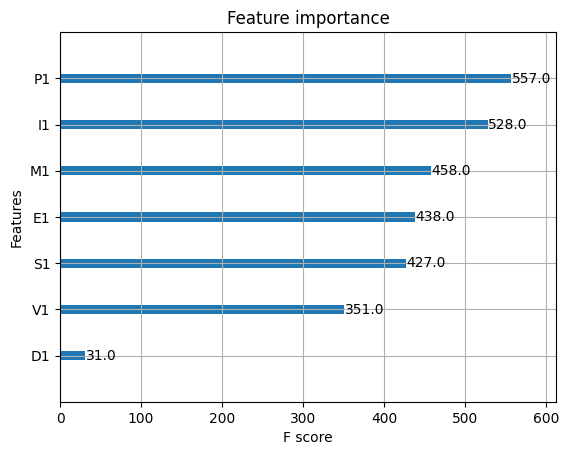

In [9]:
# xgb.plot_importance(xg_reg, max_num_features=10)
# plt.show()
xgb.plot_importance(final_model, max_num_features=10) 
plt.savefig("feature_importance.png")

In [10]:
def predict(test: pl.DataFrame) -> float:
    data = test.to_pandas()
    data = data[test_cols].copy()
    y_pred = xg_reg.predict(data)
    pred = np.clip(y_pred, 0.0, 2.0)[0]
    print(f"pred: {pred}")
    return float(pred)

In [11]:
# When your notebook is run on the hidden test set, inference_server.serve must be called within 15 minutes of the notebook starting
# or the gateway will throw an error. If you need more than 15 minutes to load your model you can do so during the very
# first `predict` call, which does not have the usual 1 minute response deadline.
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))


pred: 0.504436731338501
pred: 0.48078247904777527
pred: 0.5200136303901672
pred: 0.47660964727401733
pred: 0.4776775538921356
pred: 0.5044361352920532
pred: 0.4884227514266968
pred: 0.4561435282230377
pred: 0.4793638586997986
pred: 0.5095714330673218
